In [382]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import warnings
warnings.filterwarnings("ignore")
from pandas.tseries.offsets import Hour

from google.colab import drive
drive.mount('/content/drive')
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [285]:
df = pd.read_csv('/content/drive/MyDrive/394_points.csv', usecols=[0,11], index_col=[0], parse_dates=[0])
df.tail()

,House Plant Condenser Water Pump 20 Cwp20kW (Unit: kW)
timestamp,
2019-01-16 10:00:00,NaN
2019-01-16 11:00:00,NaN
2019-01-16 12:00:00,NaN
2019-01-16 13:00:00,NaN
2019-01-16 14:00:00,NaN


In [286]:
df = df.dropna()
df.tail()

,House Plant Condenser Water Pump 20 Cwp20kW (Unit: kW)
timestamp,
2019-01-01 00:00:00,0.035
2019-01-01 01:00:00,0.050
2019-01-01 02:00:00,0.050
2019-01-01 03:00:00,0.050
2019-01-01 04:00:00,0.050


In [287]:
monthly_data = df.resample('D').sum()

In [288]:
# rename the column
monthly_data = monthly_data.rename(columns={monthly_data.columns[0]:'y'})
monthly_data.tail()

,y
timestamp,
2018-12-28,4.3900
2018-12-29,5.0200
2018-12-30,4.5925
2018-12-31,3.5100
2019-01-01,0.2350


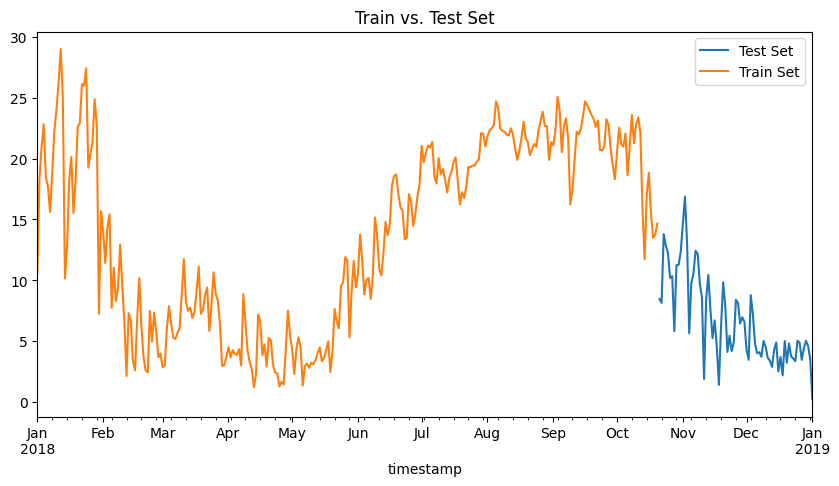

In [366]:
# calculate the split based on percentage
total_rows = len(monthly_data)
split_index = int(total_rows * 0.8)  # 70% of the data
split_date = monthly_data.index[split_index]

#split_date = 2018-01-01 # enter data manually

train_set = monthly_data.loc[monthly_data.index <= split_date].copy()
test_set = monthly_data.loc[monthly_data.index > split_date].copy()

# visualize the train and test split
test_set.rename(columns = {'y': 'Test Set'}).join(train_set.rename(columns = {'y': 'Train Set'}), how = 'outer')\
.plot(figsize = (10,5), title = 'Train vs. Test Set')
plt.show()

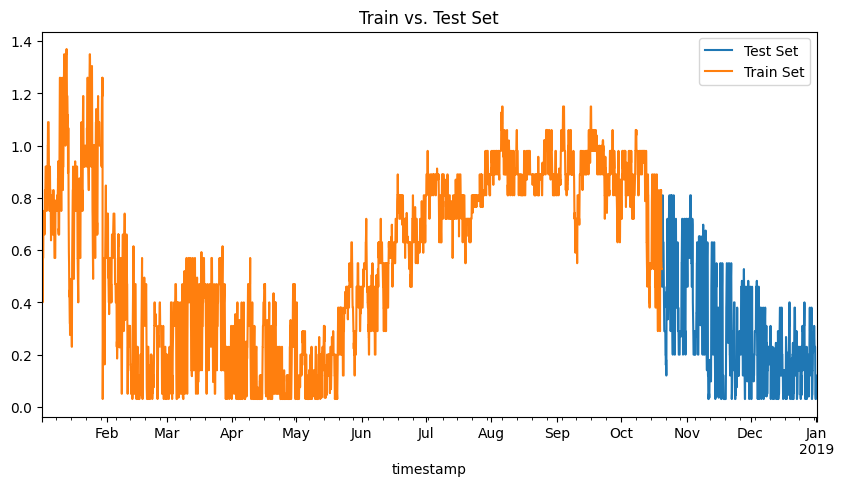

In [262]:
# calculate the split based on percentage
total_rows = len(df)
split_index = int(total_rows * 0.8)  # 70% of the data
split_date = df.index[split_index]

#split_date = 2018-01-01 # enter data manually

train_set = df.loc[df.index <= split_date].copy()
test_set = df.loc[df.index > split_date].copy()

# visualize the train and test split
test_set.rename(columns = {'y': 'Test Set'}).join(train_set.rename(columns = {'y': 'Train Set'}), how = 'outer')\
.plot(figsize = (10,5), title = 'Train vs. Test Set')
plt.show()

In [367]:
scaler = MinMaxScaler()
scaler.fit(train_set)
train = scaler.transform(train_set)

In [368]:
n_input = len(test_set)
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=32)

In [369]:
model = Sequential()
model.add(LSTM(300, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse')
history = model.fit_generator(generator,epochs=100,verbose=1)

Epoch 1/100
7/7 [==============================] - 3s 125ms/step - loss: 0.2677
Epoch 2/100
7/7 [==============================] - 1s 125ms/step - loss: 0.2487
Epoch 3/100
7/7 [==============================] - 1s 124ms/step - loss: 0.2250
Epoch 4/100
7/7 [==============================] - 1s 124ms/step - loss: 0.2063
Epoch 5/100
7/7 [==============================] - 1s 129ms/step - loss: 0.1810
Epoch 6/100
7/7 [==============================] - 1s 124ms/step - loss: 0.1558
Epoch 7/100
7/7 [==============================] - 1s 128ms/step - loss: 0.1233
Epoch 8/100
7/7 [==============================] - 1s 123ms/step - loss: 0.0899
Epoch 9/100
7/7 [==============================] - 1s 147ms/step - loss: 0.0344
Epoch 10/100
7/7 [==============================] - 1s 171ms/step - loss: 0.0208
Epoch 11/100
7/7 [==============================] - 1s 186ms/step - loss: 0.0168
Epoch 12/100
7/7 [==============================] - 1s 187ms/step - loss: 0.0177
Epoch 13/100
7/7 [===================

In [370]:
pred_list = []
batch = train[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

1/1 [==============================] - 0s 31ms/step


In [371]:
add_hours = [train_set.index[-1] + DateOffset(days=x) for x in range(1, n_input + 1)]

future_dates = pd.DataFrame(index=add_hours, columns=train_set.columns)
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])
df_proj = pd.concat([monthly_data, df_predict], axis=1)

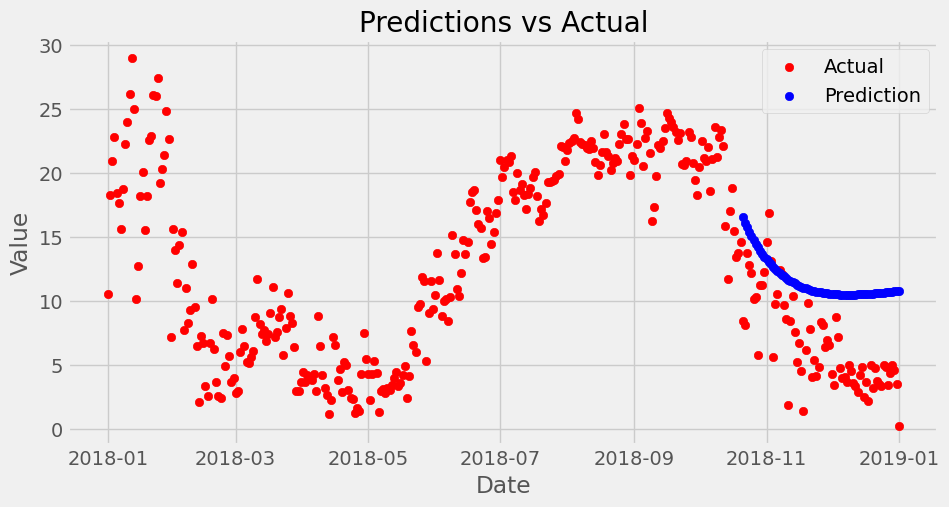

In [383]:
fig, ax = plt.subplots(figsize=(10, 5))


ax.scatter(monthly_data.index, monthly_data['y'], color='r', label='Actual')


ax.scatter(df_proj.index, df_proj['Prediction'], color='b', label='Prediction')

#ax.set_xlim(pd.Timestamp('2018-10-01'), pd.Timestamp('2018-10-10'))


ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Predictions vs Actual')
ax.legend()
plt.show()

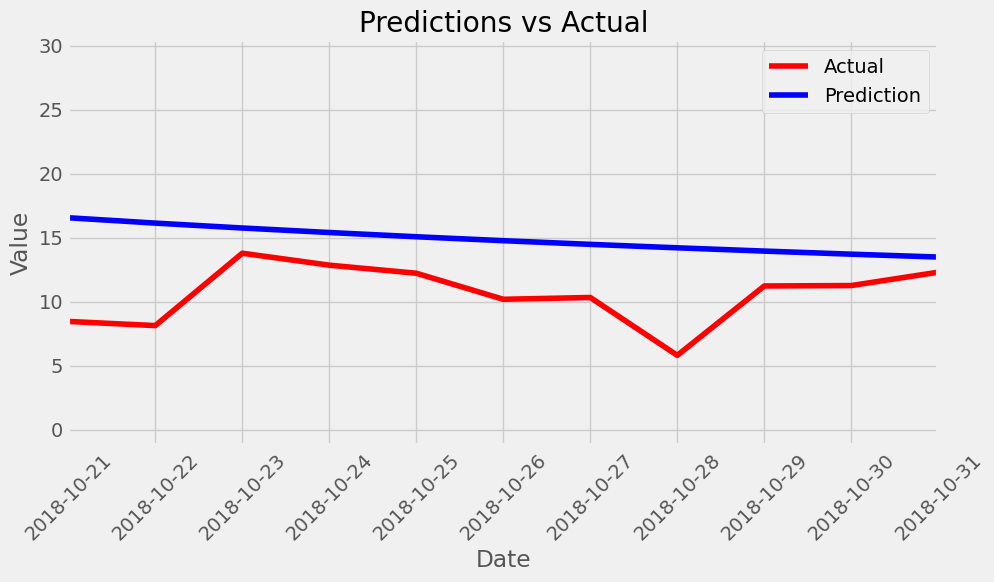

In [385]:
fig, ax = plt.subplots(figsize=(10, 5))


ax.plot(monthly_data.index, monthly_data['y'], color='r', label='Actual')


ax.plot(df_proj.index, df_proj['Prediction'], color='b', label='Prediction')

ax.set_xlim(pd.Timestamp('2018-10-21'), pd.Timestamp('2018-10-31'))


ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Predictions vs Actual')
plt.xticks(rotation=45)
ax.legend()
plt.show()

In [386]:
df_proj.loc['2018-10-21': '2019-01-01']

,y,Prediction
2018-10-21,8.4625,16.561524
2018-10-22,8.1375,16.143170
2018-10-23,13.7900,15.761179
2018-10-24,12.8575,15.407967
2018-10-25,12.2275,15.078234
...,...,...
2018-12-28,4.3900,10.725405
2018-12-29,5.0200,10.742773
2018-12-30,4.5925,10.761254
2018-12-31,3.5100,10.780393
